# Climate Modelling Project - 1D Graphics

---------------

## 0. Import Libraries

In [1]:
import cartopy
import geopandas as gpd
import matplotlib.dates as mdates
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import xarray as xr
import xskillscore as xs
from matplotlib.colors import BoundaryNorm

from functions import *
from visualization_codes import plot_facet_map

%load_ext autoreload
%autoreload 2
%reload_ext autoreload

----------

## 1. Open Data

#### **BELOW, YOU SHOULD CHECK THE PARAMETERS**

In [2]:
# Parameters to change ------------
is_single = False
model_var = 'QV' # possible for single: PMSL, RELHUM_2M, TOT_PREC, T_2M, U_10M, V_10M
                 # possible for pressure: FI, RELHUM, T, QV
era5_var = 'q' # possible for single: u10, v10, t2m, msl, tp
                 # possible for pressure: z, t, q
model_level = 'pl'
plevel = 85000 # in Pa (if using model_level=sfc, this must be 100000 (one hundred thousand Pa))
il = 'İZMİR' # choose province to clip (capital letters)
    
# ----------------

path = r'Data/'
single = 'Merged_New_Single.nc'
pressure = 'Merged_New_Pressure.nc'
shapefile = r'tr_shapefiles/Iller_HGK_6360_Kanun_Sonrasi.shp'

if is_single:
    
    # model data
    dt = xr.open_dataset(path + single).sel(time = '2013')[model_var]
    # era5 data
    dt_era5 = xr.open_dataset(path + 'ERA5/single_level_era5.nc')[era5_var]

else:
    
    # model data
    dt = xr.open_dataset(path + pressure).sel(time = '2013', pressure=plevel)[model_var]
    # era5 data
    dt_era5 = xr.open_dataset(path + 'ERA5/pressure_level_era5.nc').sel(level=plevel/100)[era5_var]

# adjust units to known units
dt = adjust_unit(dt, model_var)
dt_era5 = adjust_unit(dt_era5, era5_var)

# shapefile
shapefile_dt = gpd.read_file(path + shapefile)

In [3]:
dt

<xarray.DataArray 'QV' (time: 1460, rlat: 48, rlon: 62)>
array([[[4.363671  , 4.376473  , 4.38097   , ..., 4.2088914 ,
         4.140541  , 4.0927925 ],
        [4.367415  , 4.3765793 , 4.3820157 , ..., 4.1397004 ,
         4.1182556 , 4.099882  ],
        [4.369528  , 4.374484  , 4.3771133 , ..., 4.154747  ,
         4.1219306 , 4.105586  ],
        ...,
        [1.0487195 , 1.261577  , 1.4085224 , ..., 0.9861686 ,
         0.98248374, 0.9696667 ],
        [1.6184417 , 1.960866  , 1.8983151 , ..., 1.0369276 ,
         1.0329458 , 1.0139115 ],
        [2.021478  , 2.2456775 , 2.233148  , ..., 0.9243816 ,
         0.940505  , 0.94024944]],

       [[4.0122495 , 4.055763  , 4.0922084 , ..., 4.066946  ,
         3.996388  , 3.9684134 ],
        [4.005705  , 4.0273876 , 4.0459266 , ..., 3.9587123 ,
         3.9552631 , 3.9748573 ],
        [3.9881506 , 4.0050845 , 4.0050173 , ..., 3.9212909 ,
         3.8920527 , 3.9233224 ],
...
        [4.697435  , 4.5758524 , 4.4785323 , ..., 2.818114  ,
         2.497312  , 2.2455757 ],
        [4.2709713 , 4.015525  , 3.773302  , ..., 2.738924  ,
         2.4142277 , 2.1790097 ],
        [3.8497148 , 3.432147  , 3.7347364 , ..., 2.66456   ,
         2.3535213 , 2.1456296 ]],

       [[5.384514  , 5.521033  , 5.6602554 , ..., 4.085834  ,
         4.037397  , 4.039572  ],
        [5.110235  , 5.3066816 , 5.519699  , ..., 3.9689438 ,
         3.934164  , 3.9436357 ],
        [4.816316  , 5.082917  , 5.3616242 , ..., 3.8907096 ,
         3.8660011 , 3.8857992 ],
        ...,
        [4.474916  , 4.5022464 , 4.5668006 , ..., 2.5041342 ,
         2.300748  , 2.2181737 ],
        [4.413547  , 4.1955075 , 4.061996  , ..., 2.3821368 ,
         2.2033372 , 2.1516178 ],
        [3.9816074 , 3.7583177 , 3.782778  , ..., 2.3062263 ,
         2.1719785 , 2.1339238 ]]], dtype=float32)
Coordinates:
    lat       (rlat, rlon) float32 ...
    lon       (rlat, rlon) float32 ...
    pressure  float32 8.5e+04
  * rlat      (rlat) float32 -3.16 -2.94 -2.72 -2.5 ... 6.52 6.74 6.96 7.18
  * rlon      (rlon) float32 -8.78 -8.56 -8.34 -8.12 -7.9 ... 3.98 4.2 4.42 4.64
  * time      (time) datetime64[ns] 2013-01-01 ... 2013-12-31T18:00:00

In [4]:
dt_era5

<xarray.DataArray 'q' (time: 8760, latitude: 81, longitude: 101)>
array([[[1.9384991 , 1.889742  , 1.8656533 , ..., 2.2269785 ,
         2.28183   , 2.3657036 ],
        [1.7893254 , 1.7396976 , 1.6929722 , ..., 2.2661583 ,
         2.3361015 , 2.4205558 ],
        [1.6738176 , 1.6491487 , 1.6024234 , ..., 2.3047576 ,
         2.3752813 , 2.455382  ],
        ...,
        [4.296833  , 4.019963  , 4.0008082 , ..., 5.1303473 ,
         5.2867765 , 5.3869023 ],
        [4.761767  , 4.4050856 , 4.3902845 , ..., 5.1294765 ,
         5.342789  , 5.5549407 ],
        [4.8192306 , 4.6096916 , 4.5353947 , ..., 5.123672  ,
         5.562486  , 5.701212  ]],

       [[2.0493631 , 1.9875462 , 1.93995   , ..., 2.1477482 ,
         2.15007   , 2.1631298 ],
        [1.8406943 , 1.7771362 , 1.7214139 , ..., 2.1602273 ,
         2.1819942 , 2.1965053 ],
        [1.6714958 , 1.6340572 , 1.5780447 , ..., 2.1715462 ,
         2.1936028 , 2.2144988 ],
...
        [5.169527  , 5.009906  , 4.8610225 , ..., 4.7231674 ,
         4.723748  , 4.693565  ],
        [5.2449846 , 4.8964295 , 4.6453886 , ..., 4.749868  ,
         4.7446437 , 4.7098174 ],
        [5.119029  , 4.8424487 , 4.539748  , ..., 4.7429028 ,
         4.7550917 , 4.780341  ]],

       [[3.021893  , 3.2212749 , 3.3774137 , ..., 1.0109534 ,
         1.0600007 , 1.0939566 ],
        [3.0314703 , 3.22795   , 3.3962777 , ..., 0.934625  ,
         0.94942653, 0.9819306 ],
        [3.0932875 , 3.2511675 , 3.4203665 , ..., 0.87454915,
         0.88935065, 0.9085052 ],
        ...,
        [5.013969  , 4.890915  , 4.804139  , ..., 4.692694  ,
         4.6979184 , 4.683117  ],
        [5.086524  , 4.8241644 , 4.63407   , ..., 4.731874  ,
         4.7402906 , 4.7089467 ],
        [4.863925  , 4.7466755 , 4.5481644 , ..., 4.730423  ,
         4.7545114 , 4.764089  ]]], dtype=float32)
Coordinates:
  * longitude  (longitude) float32 15.0 15.25 15.5 15.75 ... 39.5 39.75 40.0
  * latitude   (latitude) float32 50.0 49.75 49.5 49.25 ... 30.5 30.25 30.0
    level      int32 850
  * time       (time) datetime64[ns] 2013-01-01 ... 2013-12-31T23:00:00

----------

## 2. Functions

In [5]:
# Retrieved functions from function.py in the current directory

-------------

## 3 Assign Projection Info to Datasets

### 3.1 Model Data

In [6]:
# General data information
crs_parameters = {'pole_longitude': -151.0,
                  'pole_latitude': 53.0,
                  }
crs_data = cartopy.crs.RotatedPole(**crs_parameters).proj4_params
x_dims = 'rlon'
y_dims = 'rlat'

# assign proj info
dt = assing_proj_info(dt, crs_data, x_dims, y_dims)

### 3.2 ERA5 Data

In [7]:
# General data information
crs_data_era5 = 4326
x_dims_era5 = 'longitude'
y_dims_era5 = 'latitude'

# assign proj info
dt_era5 = assing_proj_info(dt_era5, crs_data_era5, x_dims_era5, y_dims_era5)

## 4. Reproject ERA5 Matching Model Data

In [8]:
# single dt
dt_era5_reprojected = dt_era5.rio.reproject_match(dt) \
                              .rename({'y':'rlat', 'x':'rlon', })
dt_era5_reprojected = dt_era5_reprojected.assign_coords(dict(
                            lon=(["rlat", "rlon"], dt['lon'].values),
                            lat=(["rlat", "rlon"], dt['lat'].values)))

In [9]:
dt_era5_reprojected

<xarray.DataArray 'q' (time: 8760, rlat: 48, rlon: 62)>
array([[[3.9703348 , 4.2115083 , 4.3751926 , ..., 3.9241896 ,
         3.905906  , 3.7892368 ],
        [3.9668522 , 4.2115083 , 4.3751926 , ..., 3.9984863 ,
         3.9984863 , 3.8882024 ],
        [4.0460825 , 4.214411  , 4.250688  , ..., 4.0513062 ,
         4.024316  , 3.9331865 ],
        ...,
        [1.7080637 , 1.660177  , 1.7411485 , ..., 1.237616  ,
         1.174638  , 1.1093384 ],
        [2.040076  , 2.0125053 , 1.9353064 , ..., 1.2393566 ,
         1.2384868 , 1.1026627 ],
        [2.040076  , 2.1526818 , 1.9672308 , ..., 1.1836346 ,
         1.2312307 , 1.2152689 ]],

       [[3.917805  , 4.2210855 , 4.4178553 , ..., 4.018221  ,
         3.9302843 , 3.7776282 ],
        [3.9476976 , 4.2210855 , 4.4178553 , ..., 4.118057  ,
         4.058562  , 3.8995206 ],
        [4.0327325 , 4.235887  , 4.3177295 , ..., 4.140404  ,
         4.1078997 , 3.9729466 ],
...
        [4.813426  , 4.8343225 , 4.763218  , ..., 2.0328207 ,
         2.0368836 , 2.051975  ],
        [4.904556  , 4.94983   , 4.8157477 , ..., 2.171256  ,
         2.197956  , 2.1936028 ],
        [4.904556  , 4.8824987 , 4.784694  , ..., 2.3938553 ,
         2.421426  , 2.3758616 ]],

       [[2.7804296 , 2.8605304 , 3.2224357 , ..., 4.333691  ,
         4.3783855 , 4.335142  ],
        [2.9092875 , 2.8605304 , 3.2224357 , ..., 4.08236   ,
         4.0936785 , 4.0425997 ],
        [3.045111  , 2.9516597 , 2.8582084 , ..., 3.551546  ,
         3.4728963 , 3.4418428 ],
        ...,
        [4.855218  , 4.8679876 , 4.7951427 , ..., 2.0571995 ,
         2.0630033 , 2.0763538 ],
        [4.9695654 , 4.98959   , 4.83142   , ..., 2.2072434 ,
         2.2232053 , 2.2069533 ],
        [4.9695654 , 4.982625  , 4.840997  , ..., 2.440581  ,
         2.4504485 , 2.3871806 ]]], dtype=float32)
Coordinates:
  * rlon         (rlon) float64 -8.78 -8.56 -8.34 -8.12 ... 3.98 4.2 4.42 4.64
  * rlat         (rlat) float64 -3.16 -2.94 -2.72 -2.5 ... 6.52 6.74 6.96 7.18
    level        int32 850
  * time         (time) datetime64[ns] 2013-01-01 ... 2013-12-31T23:00:00
    spatial_ref  int64 0
    lon          (rlat, rlon) float32 18.49 18.75 19.01 ... 34.8 35.11 35.41
    lat          (rlat, rlon) float32 33.36 33.38 33.4 ... 44.05 44.04 44.02
Attributes:
    _FillValue:  3.402823466e+38

### 4.2 Interpolate ERA5 Data

In [10]:
rlat, rlon, time = dt.indexes.values()

# interpolate month averages
dt_era5_reprojected = dt_era5_reprojected.interp(rlon=rlon, rlat=rlat, method="nearest")

------------

## 5. Calculate Spatial Skill Scores

### 5.1 Resample ERA5 Data to 6 Hourly

In [11]:
if era5_var == 'tp':
    dt_era5_reprojected_resampled = dt_era5_reprojected.resample(time = '6H').sum()
else:
    dt_era5_reprojected_resampled = dt_era5_reprojected.resample(time = '6H').mean()

### 5.2 List of Skill Scores

In [12]:
skill_list = []

methods = [
    xs.pearson_r,
    xs.spearman_r,
    xs.r2,
    xs.mae,
    xs.rmse,
]

for method in methods:
    
    name = method.__name__
    score = method(dt, dt_era5_reprojected_resampled, dim='time')
    score = score.assign_coords({'method':name})
    score['method'] = score['method'].astype(object)
    skill_list.append(score)
    
xr_skill = xr.concat(skill_list, dim='method')

Use pearson, spearman, and r2 together in the graphic. Use the rest of the methods together in the graphic

In [13]:
xr_skill_corr = xr_skill.where(xr_skill['method'] \
                        .isin(['pearson_r', 'spearman_r', 'r2']), drop=True)

xr_skill_dist = xr_skill.where(xr_skill['method'] \
                        .isin(['mae', 'rmse']), drop=True)

In [14]:
xr_skill_corr

<xarray.DataArray (method: 3, rlat: 48, rlon: 62)>
array([[[0.86930543, 0.86874378, 0.86942464, ..., 0.86936134,
         0.87004364, 0.87670696],
        [0.87409282, 0.87863392, 0.87760723, ..., 0.86874926,
         0.86759996, 0.87647456],
        [0.8748709 , 0.87792051, 0.8817386 , ..., 0.8660118 ,
         0.86118436, 0.87025398],
        ...,
        [0.89410818, 0.89184833, 0.88893235, ..., 0.93605918,
         0.93505335, 0.93363243],
        [0.9121334 , 0.92286545, 0.92386085, ..., 0.9370203 ,
         0.93555301, 0.93553168],
        [0.90434611, 0.92032748, 0.92239684, ..., 0.94076616,
         0.93942595, 0.9382472 ]],

       [[0.86446205, 0.86454482, 0.86860487, ..., 0.88284687,
         0.87876943, 0.88543249],
        [0.86842832, 0.87509794, 0.87749433, ..., 0.88075348,
         0.87648986, 0.88625869],
        [0.86911201, 0.87469374, 0.88133594, ..., 0.87909386,
         0.8726747 , 0.88126348],
...
        [0.90337218, 0.90689663, 0.90870089, ..., 0.94184531,
         0.94100847, 0.93931448],
        [0.92180546, 0.93683836, 0.93928625, ..., 0.94291509,
         0.94152083, 0.94131456],
        [0.91777124, 0.93127212, 0.93475214, ..., 0.94579268,
         0.94493819, 0.94423379]],

       [[0.7008689 , 0.69427037, 0.69255853, ..., 0.69182086,
         0.68977296, 0.71971416],
        [0.70581532, 0.71053082, 0.70602298, ..., 0.69302952,
         0.68951511, 0.7231639 ],
        [0.70766401, 0.7084856 , 0.71631056, ..., 0.68478328,
         0.67636859, 0.71044809],
        ...,
        [0.76247811, 0.76418352, 0.74368191, ..., 0.86347425,
         0.8614037 , 0.85792053],
        [0.80959171, 0.84063125, 0.84068763, ..., 0.8682875 ,
         0.86519074, 0.8643983 ],
        [0.79221773, 0.83508545, 0.84445441, ..., 0.87662625,
         0.87386286, 0.86957681]]])
Coordinates:
    lat          (rlat, rlon) float32 33.36 33.38 33.4 ... 44.05 44.04 44.02
    lon          (rlat, rlon) float32 18.49 18.75 19.01 ... 34.8 35.11 35.41
    pressure     float32 8.5e+04
  * rlat         (rlat) float32 -3.16 -2.94 -2.72 -2.5 ... 6.52 6.74 6.96 7.18
  * rlon         (rlon) float32 -8.78 -8.56 -8.34 -8.12 ... 3.98 4.2 4.42 4.64
    spatial_ref  int64 0
    level        int32 850
  * method       (method) object 'pearson_r' 'spearman_r' 'r2'

In [15]:
xr_skill_dist

<xarray.DataArray (method: 2, rlat: 48, rlon: 62)>
array([[[0.69955361, 0.70802504, 0.71256441, ..., 0.7041344 ,
         0.71781951, 0.68449491],
        [0.69100422, 0.68727136, 0.69593084, ..., 0.71214515,
         0.72189015, 0.68455356],
        [0.69650632, 0.690431  , 0.68614823, ..., 0.72753739,
         0.73732942, 0.69857967],
        ...,
        [0.82728529, 0.84048545, 0.90260947, ..., 0.5675112 ,
         0.57512963, 0.58361179],
        [0.71466786, 0.64549702, 0.64335763, ..., 0.56145394,
         0.56910723, 0.57380164],
        [0.71555722, 0.64691651, 0.63488102, ..., 0.54962808,
         0.55390418, 0.56381261]],

       [[0.96159601, 0.97436714, 0.98679119, ..., 0.94180942,
         0.94938195, 0.90542978],
        [0.94856071, 0.94303739, 0.96126854, ..., 0.94754356,
         0.95592523, 0.90585363],
        [0.9486658 , 0.9484989 , 0.9462204 , ..., 0.96623892,
         0.97999275, 0.92991179],
        ...,
        [1.13672543, 1.17044175, 1.2684859 , ..., 0.76508993,
         0.77147287, 0.77965266],
        [0.99607134, 0.90490872, 0.92274815, ..., 0.76057786,
         0.76902497, 0.76815021],
        [1.01233196, 0.87887925, 0.87950969, ..., 0.74106318,
         0.7472744 , 0.75545961]]])
Coordinates:
    lat          (rlat, rlon) float32 33.36 33.38 33.4 ... 44.05 44.04 44.02
    lon          (rlat, rlon) float32 18.49 18.75 19.01 ... 34.8 35.11 35.41
    pressure     float32 8.5e+04
  * rlat         (rlat) float32 -3.16 -2.94 -2.72 -2.5 ... 6.52 6.74 6.96 7.18
  * rlon         (rlon) float32 -8.78 -8.56 -8.34 -8.12 ... 3.98 4.2 4.42 4.64
    spatial_ref  int64 0
    level        int32 850
  * method       (method) object 'mae' 'rmse'

### 5.2 Plot Skill Scores

#### 5.2.1 Correlation Based Scores

In [16]:
print(xr_skill_corr.min())
print(xr_skill_corr.max())

<xarray.DataArray ()>
array(-0.04661882)
Coordinates:
    pressure     float32 8.5e+04
    spatial_ref  int64 0
    level        int32 850
<xarray.DataArray ()>
array(0.96836979)
Coordinates:
    pressure     float32 8.5e+04
    spatial_ref  int64 0
    level        int32 850


#### **BELOW, YOU SHOULD CHECK THE PARAMETERS**

/home/donmezk16/Downloads/anaconda3/envs/AFAD/lib/python3.9/site-packages/proplot/figure.py:94: MatplotlibDeprecationWarning: 
The 'optimize' parameter of print_jpg() was deprecated in Matplotlib 3.3 and will be removed two minor releases later. Use pil_kwargs={'optimize': ...} instead. If any parameter follows 'optimize', they should be passed as keyword, not positionally.
  result = func(self, *args, **kwargs)
/home/donmezk16/Downloads/anaconda3/envs/AFAD/lib/python3.9/site-packages/proplot/figure.py:94: MatplotlibDeprecationWarning: 
The 'progressive' parameter of print_jpg() was deprecated in Matplotlib 3.3 and will be removed two minor releases later. Use pil_kwargs={'progressive': ...} instead. If any parameter follows 'progressive', they should be passed as keyword, not positionally.
  result = func(self, *args, **kwargs)


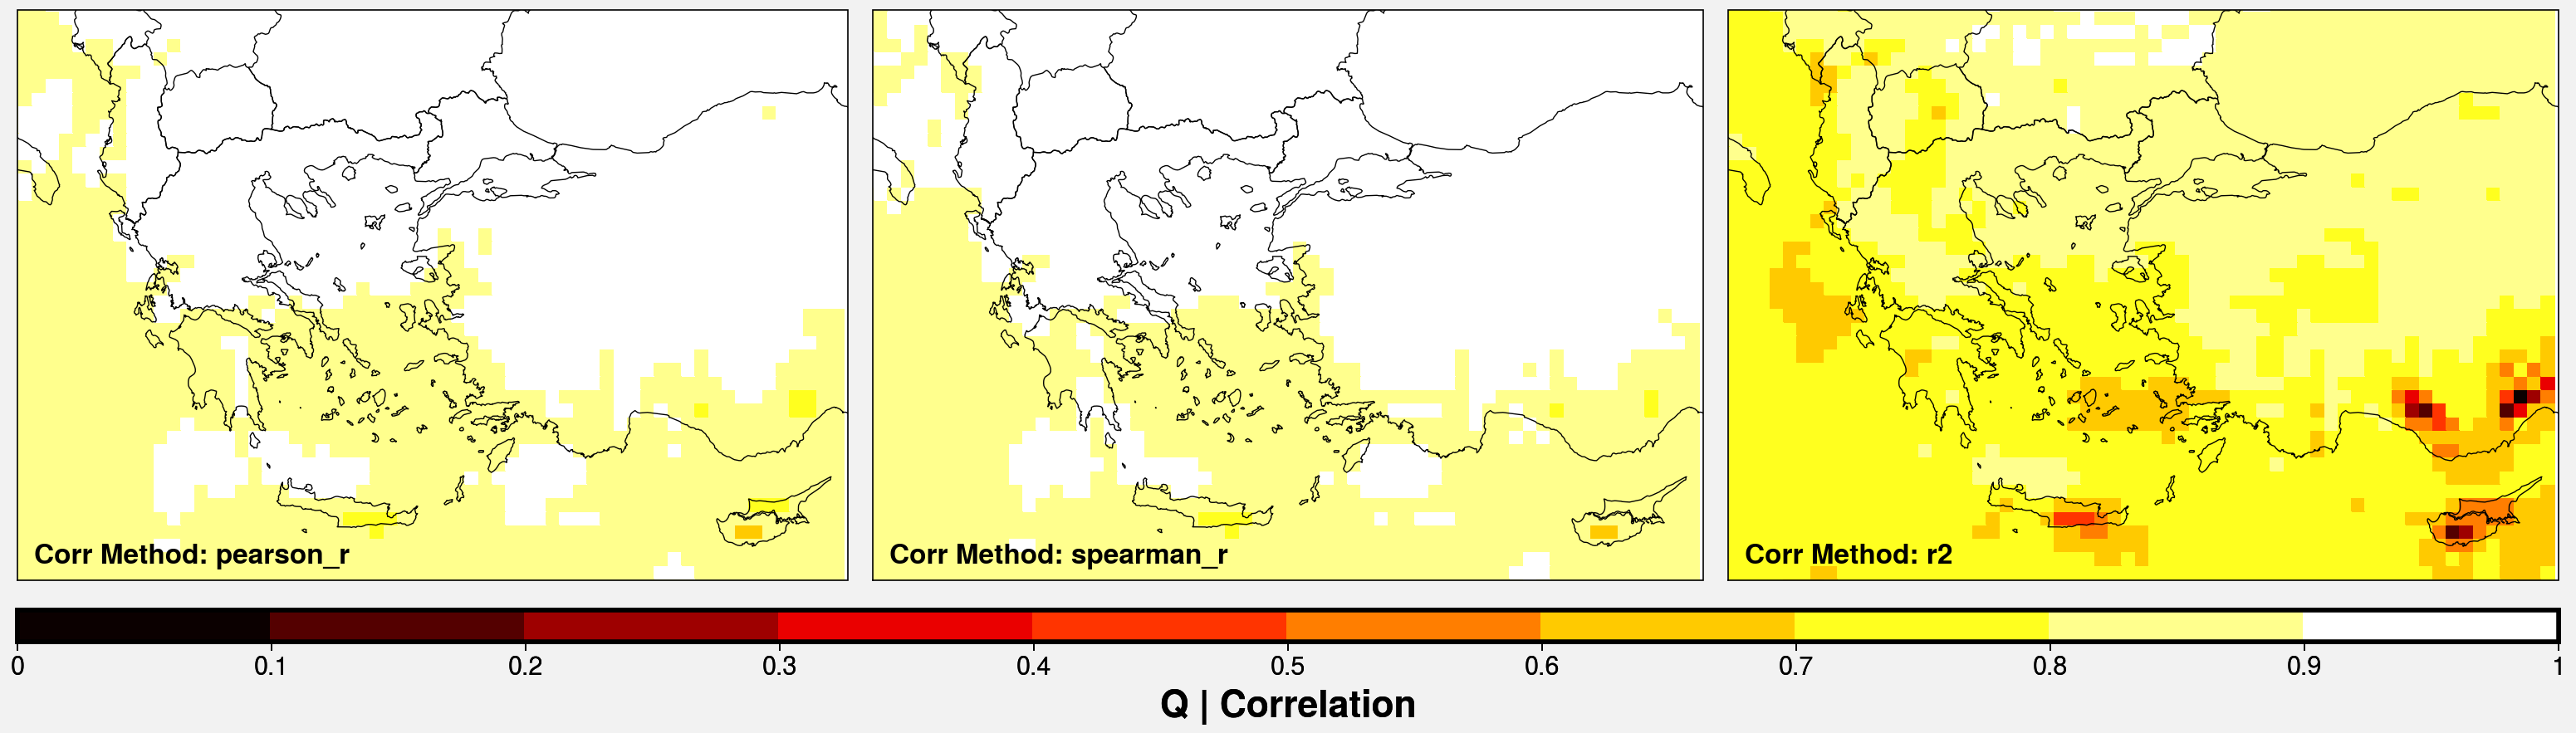

In [21]:
# Parameters to change ------------
cmap = plt.get_cmap('hot')
vmin = 0 # consider lower limit above
vmax = 1 # consider upper limit above
norm = BoundaryNorm(np.arange(vmin, vmax+0.1, 0.1), ncolors=cmap.N, clip=True)
ticks = np.arange(vmin, vmax+0.1, 0.1)

# ----------------

# data
data_df = xr_skill_corr

# graphic features
fig_array = [[1,2,3]]
graphic_no = 3
method='Corr Method'
difference_method = 'Correlation'

# projection
crs_data = cartopy.crs.RotatedPole(**crs_parameters)

plot_facet_map(data_df, cmap, vmin, vmax, norm, ticks,
               crs_data, graphic_no, era5_var, model_level,
               plevel, method, difference_method, fig_array)

#### 5.2.1 Distance Based Scores

In [22]:
print(xr_skill_dist.min())
print(xr_skill_dist.max())

<xarray.DataArray ()>
array(0.47552592)
Coordinates:
    pressure     float32 8.5e+04
    spatial_ref  int64 0
    level        int32 850
<xarray.DataArray ()>
array(1.87173271)
Coordinates:
    pressure     float32 8.5e+04
    spatial_ref  int64 0
    level        int32 850


#### **BELOW, YOU SHOULD CHECK THE PARAMETERS**

/home/donmezk16/Downloads/anaconda3/envs/AFAD/lib/python3.9/site-packages/proplot/figure.py:94: MatplotlibDeprecationWarning: 
The 'optimize' parameter of print_jpg() was deprecated in Matplotlib 3.3 and will be removed two minor releases later. Use pil_kwargs={'optimize': ...} instead. If any parameter follows 'optimize', they should be passed as keyword, not positionally.
  result = func(self, *args, **kwargs)
/home/donmezk16/Downloads/anaconda3/envs/AFAD/lib/python3.9/site-packages/proplot/figure.py:94: MatplotlibDeprecationWarning: 
The 'progressive' parameter of print_jpg() was deprecated in Matplotlib 3.3 and will be removed two minor releases later. Use pil_kwargs={'progressive': ...} instead. If any parameter follows 'progressive', they should be passed as keyword, not positionally.
  result = func(self, *args, **kwargs)


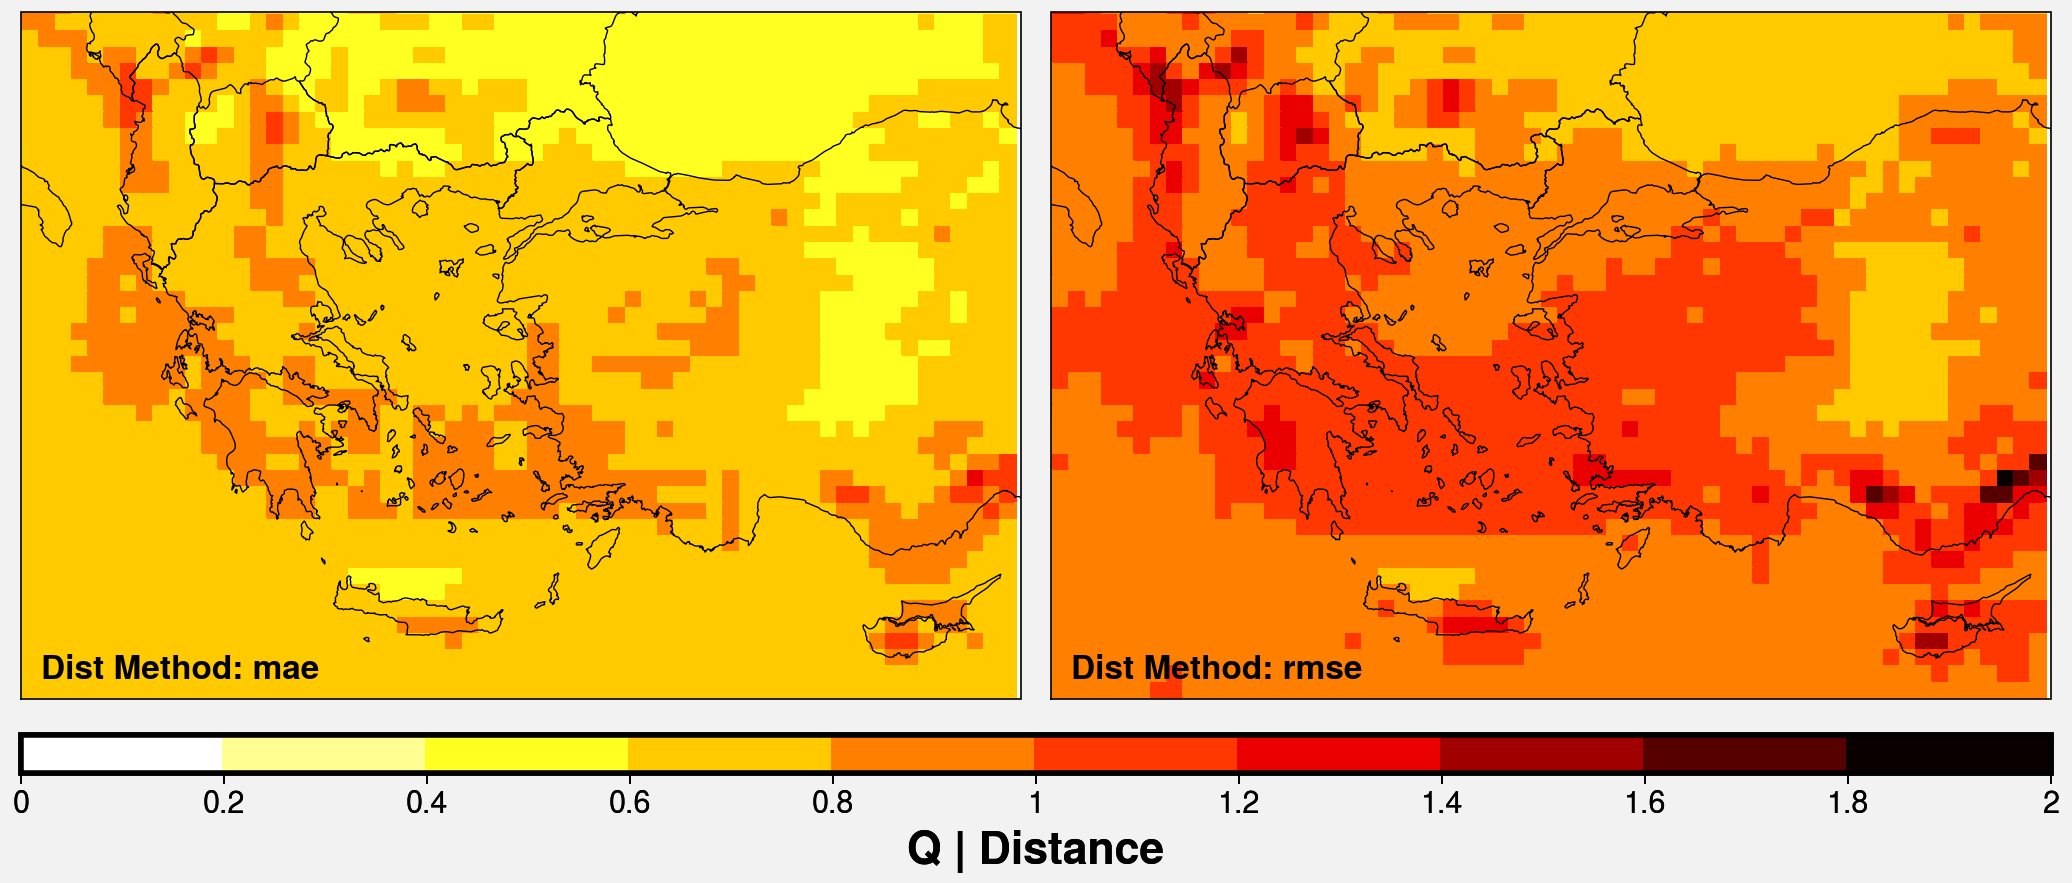

In [27]:
# Parameters to change ------------
cmap = plt.get_cmap('hot').reversed()
vmin = 0 # consider lower limit above
vmax = 2 # consider upper limit above
norm_inc = 0.2 # norm increment
ticks_inc = 0.2 # ticks increment

norm = BoundaryNorm(np.arange(vmin, vmax+norm_inc, norm_inc), ncolors=cmap.N, clip=True)
ticks = np.arange(vmin, vmax+ticks_inc, ticks_inc)

# ----------------

# data
data_df = xr_skill_dist

# graphic features
fig_array = [[1,2]]
graphic_no = 2
method='Dist Method'
difference_method = 'Distance'

# projection
crs_data = cartopy.crs.RotatedPole(**crs_parameters)

plot_facet_map(data_df, cmap, vmin, vmax, norm, ticks,
               crs_data, graphic_no, era5_var, model_level,
               plevel, method, difference_method, fig_array)

--------

## 6. Clip Data to Specific Province

In [28]:
province = shapefile_dt.query(f'IL == "{il}"')

### 6.1 Check If Clipping is Accurate by Making Data Higher Resolution

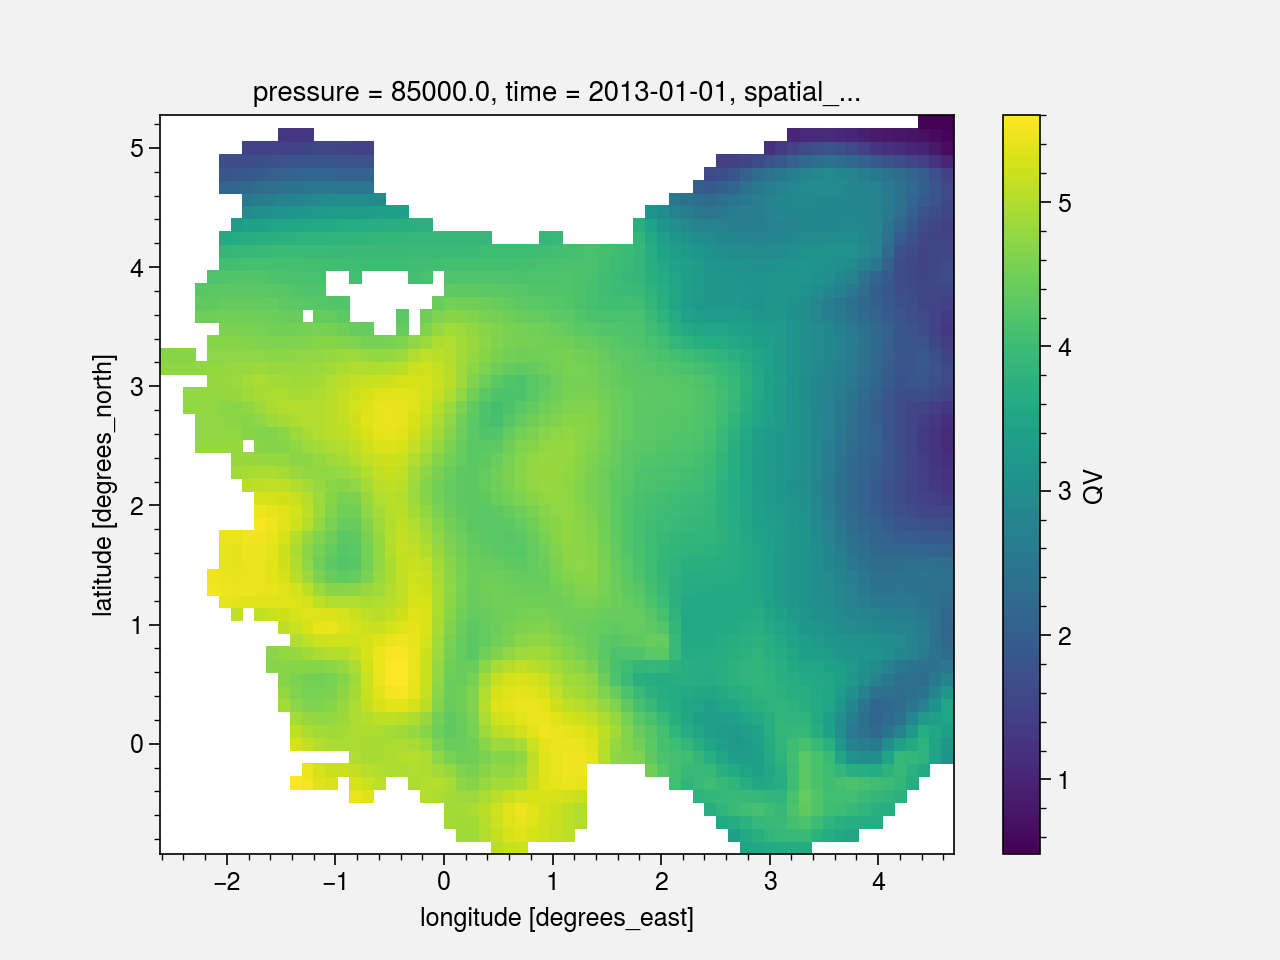

In [29]:
# test clipping accuracy
clip_to_city(higher_resolution(dt, x_dims, y_dims, 2),
             shapefile_dt, crs_data, x_dims, y_dims)[0].plot()

In [30]:
# test looks accurate: Turkey is clipped

### 6.2 Clip

In [31]:
# model
dt_clipped = clip_to_city(dt, province, crs_data, x_dims, y_dims)
# era5
dt_era5_clipped = clip_to_city(dt_era5_reprojected_resampled, province, crs_data, x_dims, y_dims)

# it adds fillvalue (IDK why?) so better change no data with np.nan
nodata = dt_era5_clipped.rio.nodata
dt_era5_clipped = dt_era5_clipped.where(dt_era5_clipped != nodata, np.nan)

-----------

## 7. Calculate Spatial Averages

In [32]:
if era5_var == 'tp':
    # sum model
    dt_clipped_mean = dt_clipped.sum(dim=[x_dims, y_dims])
    # sum era5
    dt_era5_clipped_mean = dt_era5_clipped.sum(dim=[x_dims, y_dims])
else:
    # mean model
    dt_clipped_mean = dt_clipped.mean(dim=[x_dims, y_dims])
    # mean era5
    dt_era5_clipped_mean = dt_era5_clipped.mean(dim=[x_dims, y_dims])

# difference between model and era5
mean_difference = dt_clipped_mean - dt_era5_clipped_mean

### 7.1 Lineplot

/tmp/ipykernel_861/1488289373.py:34: MatplotlibDeprecationWarning: 
The 'optimize' parameter of print_jpg() was deprecated in Matplotlib 3.3 and will be removed two minor releases later. Use pil_kwargs={'optimize': ...} instead. If any parameter follows 'optimize', they should be passed as keyword, not positionally.
  plt.savefig(f'Pictures/ts_{era5_var}_{plevel}_{il}.jpeg',
/tmp/ipykernel_861/1488289373.py:34: MatplotlibDeprecationWarning: 
The 'progressive' parameter of print_jpg() was deprecated in Matplotlib 3.3 and will be removed two minor releases later. Use pil_kwargs={'progressive': ...} instead. If any parameter follows 'progressive', they should be passed as keyword, not positionally.
  plt.savefig(f'Pictures/ts_{era5_var}_{plevel}_{il}.jpeg',


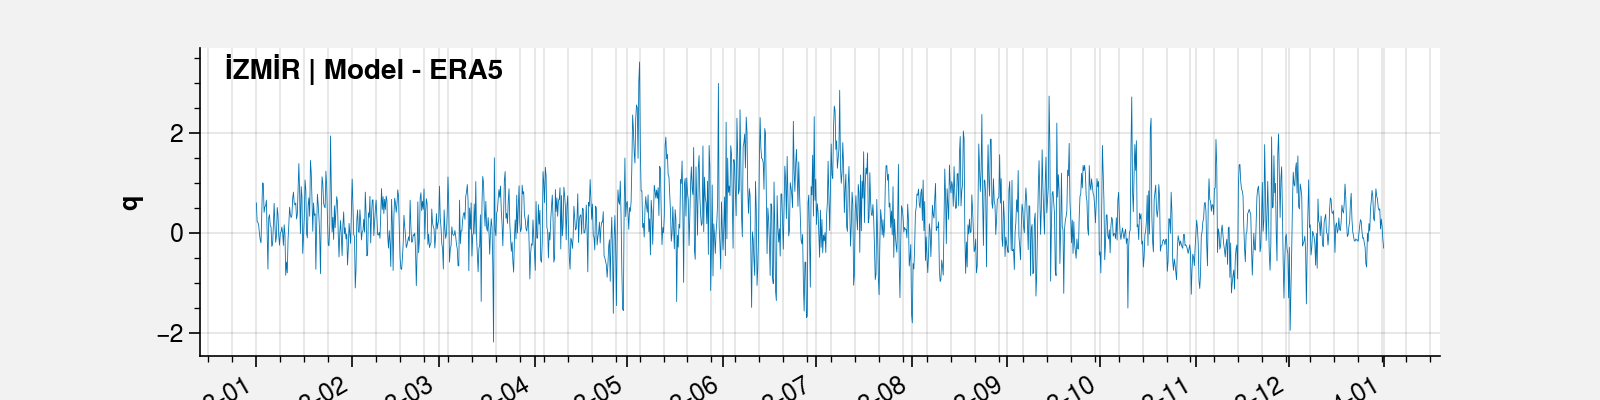

In [33]:
n_lines = 10
diff_linewidth = 1.05
alpha_value = 0.03

fig = plt.figure(figsize = (8,2))

#ax1
ax1 = fig.add_subplot(1,1,1)
mean_difference.plot(ax = ax1, linewidth=0.3,)
plt.ylabel(f'{era5_var}', fontsize=9,weight='bold')
ax1.grid(True, which='both', axis='x')

# common
ax1.set_xlabel('Date', fontsize=9, weight='bold')

#empty title
ax1.set_title( f'',
         weight='bold',transform=ax1.transAxes,
         fontsize=10, style='italic')


ax1.text(0.02, 0.9, f'{il} | Model - ERA5',
         weight='bold',transform=ax1.transAxes,
         fontsize=10,)

ax1.spines["top"].set_visible(False)
ax1.spines["right"].set_visible(False)
ax1.xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m'))

# Ensure a major tick for each week using (interval=1) 
ax1.xaxis.set_major_locator(mdates.MonthLocator(interval=1))

#savefig
plt.savefig(f'Pictures/ts_{era5_var}_{plevel}_{il}.jpeg',
            bbox_inches='tight', optimize=False,
            progressive=True, dpi=300)